In [0]:
from pyspark.sql.functions import col, sum, mean, round, lit, when, count, min, max, avg, countDistinct, desc, regexp_extract, year, coalesce, first
from pyspark.sql.types import FloatType
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName('ultra').getOrCreate()

### Data cleaning: searching for missing values and inconsistent formatting
In this phase, I'm exploring the ultra-marathon dataset, addressing data inconsistencies, missing values, and outliers.
Data are stored inside S3 buckets, so my first step is set the AWS access key ID and secret access key, then use these credentials for accessing S3 and read a CSV file located at the specified path into a DataFrame.

In [0]:
access_key_id = "XXXXXXXXXXXXXXXX"
secret_access_key = "XXXXXXXXXXXXXXXX"

spark.conf.set(
    "fs.s3a.access.key", access_key_id
)
spark.conf.set(
    "fs.s3a.secret.key", secret_access_key
)

running_df = spark.read.csv("s3://projectdata/TWO_CENTURIES_OF_UM_RACES.csv", header=True) 
running_df.show()

+-------------+-----------+-------------------+---------------------+-------------------------+-------------------+--------------------+---------------+---------------------+--------------+--------------------+---------------------+----------+
|Year of event|Event dates|         Event name|Event distance/length|Event number of finishers|Athlete performance|        Athlete club|Athlete country|Athlete year of birth|Athlete gender|Athlete age category|Athlete average speed|Athlete ID|
+-------------+-----------+-------------------+---------------------+-------------------------+-------------------+--------------------+---------------+---------------------+--------------+--------------------+---------------------+----------+
|         2018| 06.01.2018|Selva Costera (CHI)|                 50km|                       22|          4:51:39 h|               Tnfrc|            CHI|               1978.0|             M|                 M35|               10.286|         0|
|         2018| 06.01.20

After reviewing the data, I rename the column names for clarity and better data handling.

In [0]:
column_mapping = {
    "Year of event": "year_of_event",
    "Event dates": "event_dates",
    "Event name": "event_name",
    "Event distance/length": "event_distance_length",
    "Event number of finishers": "event_num_finishers",
    "Athlete performance": "athlete_performance",
    "Athlete club": "athlete_club",
    "Athlete country": "athlete_country",
    "Athlete year of birth": "athlete_year_of_birth",
    "Athlete gender": "athlete_gender",
    "Athlete age category": "athlete_age_category",
    "Athlete average speed": "athlete_average_speed",
    "Athlete ID": "athlete_id"
}

for old_col, new_col in column_mapping.items():
    running_df = running_df.withColumnRenamed(old_col, new_col)

running_df.show()

+-------------+-----------+-------------------+---------------------+-------------------+-------------------+--------------------+---------------+---------------------+--------------+--------------------+---------------------+----------+
|year_of_event|event_dates|         event_name|event_distance_length|event_num_finishers|athlete_performance|        athlete_club|athlete_country|athlete_year_of_birth|athlete_gender|athlete_age_category|athlete_average_speed|athlete_id|
+-------------+-----------+-------------------+---------------------+-------------------+-------------------+--------------------+---------------+---------------------+--------------+--------------------+---------------------+----------+
|         2018| 06.01.2018|Selva Costera (CHI)|                 50km|                 22|          4:51:39 h|               Tnfrc|            CHI|               1978.0|             M|                 M35|               10.286|         0|
|         2018| 06.01.2018|Selva Costera (CHI)| 

Ultra-marathon running races are typically defined by distance rather than time. But there are also timed ultra-marathons where participants run for a set amount of time, such as 6 hours, 12 hours, 24 hours, or even multi-day events. In these races, the goal is to cover as much distance as possible within the allotted time rather than completing a set distance. 

The dataset description states that the event_distance_length column contains both time and distance values. After verifying this fact, I decide to add another column event_type, which is determined by the content of the event_distance_length column and shows, if the value in the event_distance_length is distance or time.

In [0]:
running_df = running_df.withColumn(
    "event_type",
    when(col("event_distance_length").rlike(r"\d+[kKmMi]"), "Distance")
    .when(col("event_distance_length").rlike(r"\d+[dh]"), "Time")
    .otherwise("Unknown")
)

running_df.select("event_type").distinct().show()

+----------+
|event_type|
+----------+
|  Distance|
|   Unknown|
|      Time|
+----------+



I am verifying that the applied filtering was correct by grouping "event_type" and calculate the count and percentage for each value. According to the results of Distance (92.92%), Time (7.05%) and Unknown (0.01%), I consider the division to be correct. In practice, most races are defined by distance.

In [0]:
total_rows = running_df.count()
filtered_rows_distance = (
    running_df.groupBy("event_type")
        .agg(count("*").alias("count"))
        .withColumn("percentage", col("count") / lit(total_rows) * 100)
)
filtered_rows_distance.show(filtered_rows_distance.count(), truncate=False)

+----------+-------+--------------------+
|event_type|count  |percentage          |
+----------+-------+--------------------+
|Distance  |6933107|92.92220616134547   |
|Unknown   |1441   |0.019313260141304443|
|Time      |526647 |7.058480578513228   |
+----------+-------+--------------------+



Now I'm calculating the percentage of missing values for each column in the DataFrame. The result reveals that 37% of entries in the athlete_club column are missing, while 7% are missing for the athlete_age and athlete_year_of_birth columns. Since these informations are not crucial for my analysis, they can be excluded.

In [0]:
missing_values_per_column = running_df.select([col(c).isNull().alias(c) for c in running_df.columns])
missing_values_count = missing_values_per_column.agg(*[sum(col(c).cast("int")).alias(c) for c in missing_values_per_column.columns])

missing_values_percentage_raw = missing_values_count.select([(col(c) / total_rows * 100).alias(c) for c in running_df.columns])
 
missing_values_percentage = missing_values_percentage_raw.select([col(c).cast("int").alias(c) for c in running_df.columns])
missing_values_percentage.show()

+-------------+-----------+----------+---------------------+-------------------+-------------------+------------+---------------+---------------------+--------------+--------------------+---------------------+----------+----------+
|year_of_event|event_dates|event_name|event_distance_length|event_num_finishers|athlete_performance|athlete_club|athlete_country|athlete_year_of_birth|athlete_gender|athlete_age_category|athlete_average_speed|athlete_id|event_type|
+-------------+-----------+----------+---------------------+-------------------+-------------------+------------+---------------+---------------------+--------------+--------------------+---------------------+----------+----------+
|            0|          0|         0|                    0|                  0|                  0|          37|              0|                    7|             0|                   7|                    0|         0|         0|
+-------------+-----------+----------+---------------------+------------

Next step is to look at the athlete_country column, because it will be a part of the analysis. I want to see distinct values for the column and to see the result without truncating the output, providing a comprehensive list of unique countries and their occurrences in the dataset.

In [0]:
unique_countries = running_df.select("athlete_country").distinct().orderBy("athlete_country", ascending=True)
unique_countries.show(unique_countries.count(), truncate=False)

+---------------+
|athlete_country|
+---------------+
|null           |
|ACT            |
|AFG            |
|AHO            |
|ALB            |
|ALG            |
|AND            |
|ANG            |
|ANT            |
|ARG            |
|ARM            |
|ARU            |
|AUS            |
|AUT            |
|AZE            |
|BAH            |
|BAN            |
|BAR            |
|BDI            |
|BEL            |
|BEN            |
|BER            |
|BHU            |
|BIH            |
|BIZ            |
|BLR            |
|BOL            |
|BOT            |
|BRA            |
|BRN            |
|BRU            |
|BUL            |
|BUR            |
|CAF            |
|CAM            |
|CAN            |
|CAY            |
|CGO            |
|CHA            |
|CHI            |
|CHN            |
|CIV            |
|CMR            |
|COD            |
|COK            |
|COL            |
|COM            |
|CPV            |
|CRC            |
|CRO            |
|CUB            |
|CYP            |
|CZE      

After verifying the result from the previous step, I want to filter rows where athlete_country is "XXX" or "swe" and see how many rows contain those values. The calculation result contains 1783 records for "XXX" and 4 records for "swe". Again, this is a result that will not significantly affect the analysis, so I'll keep them in the dataset.

In [0]:
filtered_rows = (
    running_df.filter((col("athlete_country") == "XXX") | (col("athlete_country") == "swe"))
        .groupBy("athlete_country")
        .agg(sum(lit(1)).alias("count"))
)

filtered_rows.show()

+---------------+-----+
|athlete_country|count|
+---------------+-----+
|            XXX| 1783|
|            swe|    4|
+---------------+-----+



Some of the athletes have unreasonable average speed (for example 80 km/h) and it looks like a comma was placed incorrectly, so I want to filter and fix the values.

In [0]:
max_reasonable_speed = 25.0  # km/h

running_df = running_df.withColumn(
    "athlete_average_speed",
    when(col("athlete_average_speed") <= max_reasonable_speed, col("athlete_average_speed"))
    .otherwise(col("athlete_average_speed") / 1000.0)  # Convert from m/s to km/h
)

### Performance Trends Over Years 

For this part of the analysis, I focused on the period from 1970 to 2022, so that we can take a more in-depth look at the races and performances of athletes in the last 50 years.

Calculating the average speed per year, the following steps group the data by the "year_of_event" column, compute the average athlete speed, and filter the results for the years between 1970 and 2022. The subsequent visualization, presented as a line plot, depicts the trends in average athlete speed over the specified years.

The plotted data illustrates changes in average athlete speed over the years. Speed increased from approximately 7.5 km/h in 1970 to 9 km/h in 1980, reaching a peak of around 9.4 km/h in 1993. However, there were declines in 1995, 2015, and in 2020, with speeds falling below 7 km/h in 2022. Possible reasons for these drops could include changes in race difficulty, weather conditions, athlete demographics, and the growing popularity of ultra-marathons, all of which may impact average speeds.

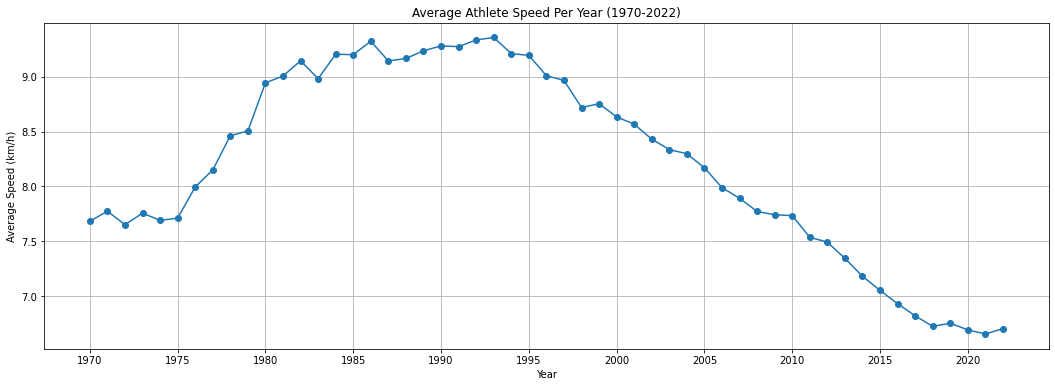

In [0]:
average_speed_per_year = running_df.groupBy("year_of_event").agg(avg("athlete_average_speed").alias("avg_speed_per_year"))
average_speed_filtered = average_speed_per_year.filter(
    (average_speed_per_year["year_of_event"] >= 1970) & (average_speed_per_year["year_of_event"] <= 2022)).orderBy("year_of_event", ascending=True)

pandas_df = average_speed_filtered.toPandas()

plt.figure(figsize=(18, 6))
plt.plot(pandas_df['year_of_event'], pandas_df['avg_speed_per_year'], marker='o', linestyle='-')
plt.title('Average Athlete Speed Per Year (1970-2022)')
plt.xlabel('Year')
plt.ylabel('Average Speed (km/h)')
plt.xticks(pandas_df['year_of_event'][::5])
plt.grid(True)
plt.show()

Now I am focusing on understanding the distribution of ultra-marathon events based on their distance for each year between 1970 and 2022. After filtering the data to include only relevant years and valid distance values, I calculate the count of each event type per year. Subsequently, I identify and select the ten most popular distances: 50km, 100km, 50mi, 90km, 60km, 56km, 45km, 55km, 100mi, and 24h.

In [0]:
events_count_filtered = running_df.filter(
    (running_df["year_of_event"] >= 1970) & 
    (running_df["year_of_event"] <= 2022) & 
    (running_df["event_distance_length"] != "None"))
events_count_per_distance_year = events_count_filtered.groupBy("year_of_event", "event_distance_length").agg(countDistinct("event_name").alias("event_count")).orderBy("event_distance_length", ascending=False)

In this part, I focus on the trends of two popular ultra-marathon distances: 50km and 100km. I filter and organize the data for each distance, creating separate plots to show the progress of races over the years. The first plot illustrates the trends in 50km races, while the second shows the progression of 100km races. 

In both plots, we observe a growth in the number of races for both 50km and 100km distances, peaking between 2005 and 2019, aligning with the surge in recreational running's popularity. A notable decline is evident in 2020, reflecting the global cancellation of numerous races due to the COVID-19 pandemic. In the subsequent two years, there is a gradual increase in race numbers, though they do not reach the peak levels seen in 2019.

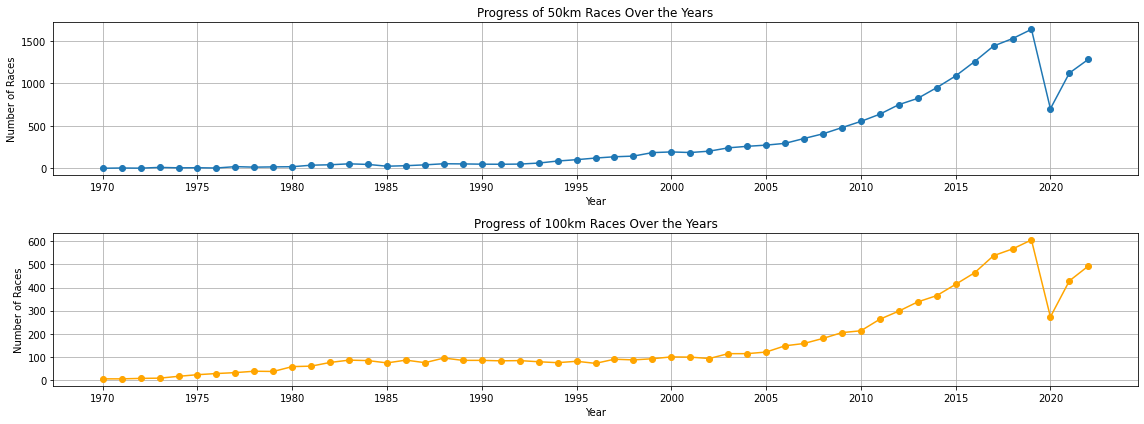

In [0]:
events_50km = events_count_per_distance_year.filter(col("event_distance_length") == "50km").orderBy("year_of_event", ascending=True)
events_100km = events_count_per_distance_year.filter(col("event_distance_length") == "100km").orderBy("year_of_event", ascending=True)

pandas_df_50km = events_50km.toPandas()
pandas_df_100km = events_100km.toPandas()
fig, axs = plt.subplots(2, 1, figsize=(16, 6))

# 50km races
axs[0].plot(pandas_df_50km['year_of_event'], pandas_df_50km['event_count'], marker='o')
axs[0].set_title('Progress of 50km Races Over the Years')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Number of Races')
axs[0].set_xticks(pandas_df_50km['year_of_event'][::5]) 
axs[0].grid(True)

# 100km races
axs[1].plot(pandas_df_100km['year_of_event'], pandas_df_100km['event_count'], marker='o', color='orange')
axs[1].set_title('Progress of 100km Races Over the Years')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Number of Races')
axs[1].set_xticks(pandas_df_100km['year_of_event'][::5]) 
axs[1].grid(True)

plt.tight_layout()
plt.show()

In this part of the analysis, I am examining the dynamics of athlete participation and the number of events over the years. The code calculates the number of athletes and the number of distinct events for each year, focusing on the period from 1970 to 2022. The results are then visualized using two line plots: one depicting the trend in the number of athletes over the years, and the other showing the evolution of the number of events (races) during the same period.

Again we can see a growth in the number of races for both number of athletes and events over the years between 2005 and 2019 with visible decrease in 2020 and gradual increase in recent years.

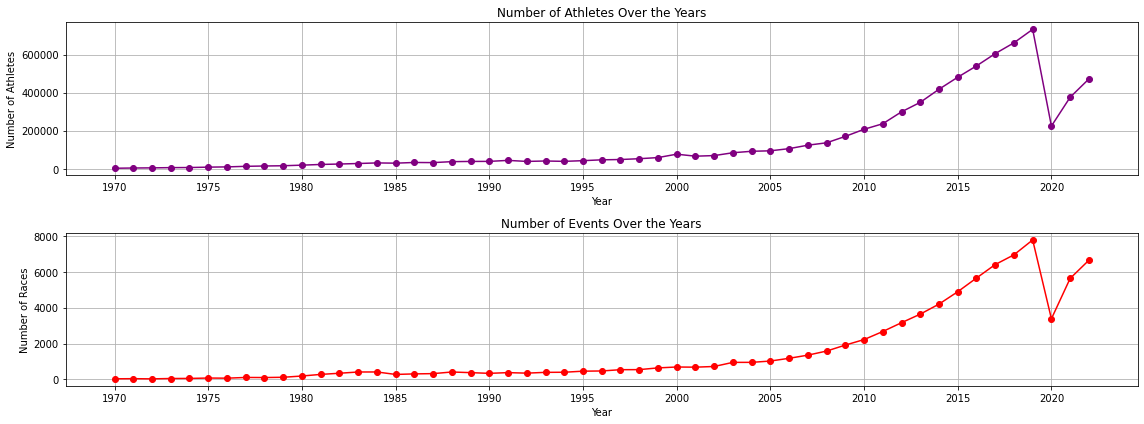

In [0]:
athletes_per_year = running_df.groupBy("year_of_event").agg(count("athlete_id").alias("num_athletes"))
athletes_per_year = athletes_per_year.filter((athletes_per_year["year_of_event"] >= 1970) & 
    (athletes_per_year["year_of_event"] <= 2022)).orderBy("year_of_event", ascending=True)

number_of_events = running_df.groupBy("year_of_event").agg(countDistinct("event_name").alias("num_of_events"))
number_of_events_time = number_of_events.filter((number_of_events["year_of_event"] >= 1970) & 
    (number_of_events["year_of_event"] <= 2022)).orderBy("year_of_event", ascending=True)

pandas_df_athletes = athletes_per_year.toPandas()
pandas_df_events = number_of_events_time.toPandas()

fig, axs = plt.subplots(2, 1, figsize=(16, 6))

# Plot for athletes 
axs[0].plot(pandas_df_athletes['year_of_event'], pandas_df_athletes['num_athletes'], marker='o', color='purple')
axs[0].set_title('Number of Athletes Over the Years')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Number of Athletes')
axs[0].set_xticks(pandas_df_athletes['year_of_event'][::5]) 
axs[0].grid(True)

# Plot for events
axs[1].plot(pandas_df_events['year_of_event'], pandas_df_events['num_of_events'], marker='o', color='red')
axs[1].set_title('Number of Events Over the Years')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Number of Races')
axs[1].set_xticks(pandas_df_events['year_of_event'][::5]) 
axs[1].grid(True)

plt.tight_layout()
plt.show()

In this section, I delve into the analysis of the most popular ultra-marathon races based on the number of participants. The code calculates the number of participants for each race and identifies the top 5 races with the highest participation. These races, including Two Oceans Marathon (RSA), Comrades Marathon - Down Run (RSA), Comrades Marathon - Up Run (RSA), 100 km Lauf Biel (SUI), and Two Oceans Marathon - 50km Split (RSA), are then further analyzed over the years. The resulting line plot visualizes the number of athletes participating in each of these top 5 races annually from 1970 to 2022, providing insights into the historical trends of athlete engagement in these renowned events.

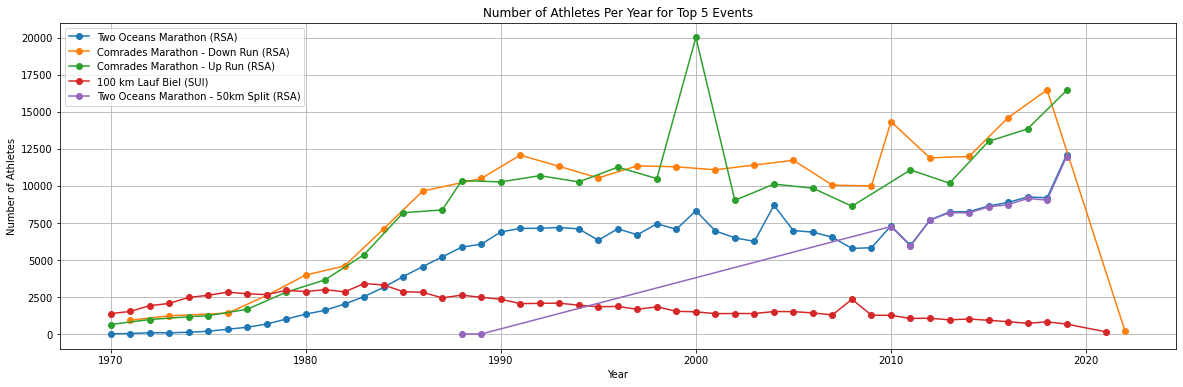

In [0]:
participants_per_race = running_df.groupBy("event_name").agg(count("athlete_id").alias("num_participants"))
top5_races = participants_per_race.orderBy("num_participants", ascending=False).limit(5)

top5_events = ["Two Oceans Marathon (RSA)", "Comrades Marathon - Down Run (RSA)", "Comrades Marathon - Up Run (RSA)", "100 km Lauf Biel (SUI)", "Two Oceans Marathon - 50km Split (RSA)"]

top5_in_time = running_df.filter((running_df["event_name"].isin(top5_events)))
top5_in_time = top5_in_time.groupBy("event_name", "year_of_event").agg(count("athlete_id").alias("num_athletes"))

top5_pd = top5_in_time.toPandas()
top5_pd["year_of_event"] = top5_pd["year_of_event"].astype(int)
top5_pd_filtered = top5_pd[(top5_pd["event_name"].isin(top5_events)) & (top5_pd["year_of_event"].between(1970, 2022))]
top5_pd_filtered = top5_pd_filtered.sort_values(by="year_of_event")

plt.figure(figsize=(20, 6))
for event_name in top5_events:
    event_data = top5_pd_filtered[top5_pd_filtered["event_name"] == event_name]
    plt.plot(event_data['year_of_event'], event_data['num_athletes'], marker='o', linestyle='-', label=event_name)  

plt.title('Number of Athletes Per Year for Top 5 Events')
plt.xlabel('Year')
plt.ylabel('Number of Athletes')
plt.legend()
plt.grid(True)
plt.show()

In this segment, I explore the relationship between the number of participants and the distance of ultra-marathon events. The code filters events classified as "Distance" and focuses on races measured in kilometers. It converts miles to kilometers and rounds the distances. The resulting data is then grouped by event distance, and the count of finishers for each distance is calculated. The data is cleaned to exclude races with extreme distances 500+ km (e.g., Athens Int. Ultramarathon Festival 5000 km) to ensure meaningful visualization. The scatter plot illustrates the correlation between event distance (in kilometers) and the number of participants, offering insights into the participation patterns across different race distances.

The scatter plot indicates that participation decreases as the distance increases. The trend is evident in the data, with races over 500 kilometers having significantly fewer participants than those under 100 kilometers.

There are several possible explanations for this trend. One possibility is that ultramarathoners are more likely to choose shorter distances as they age or gain experience. Additionally, shorter races are often more accessible and affordable, attracting a wider range of participants. Finally, longer races require more training and preparation, which may deter some potential participants.

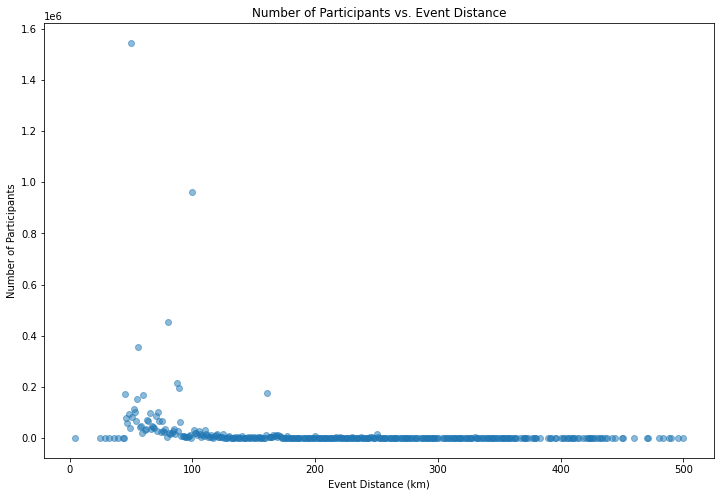

In [0]:
distance_events = running_df.filter(col("event_type").isin(["Distance"]))

distance_events = distance_events.withColumn(
    "event_distance_numeric",
    when(col("event_distance_length").contains("mi"),
         round(regexp_extract(col("event_distance_length"), r"(\d+(\.\d+)?)", 1).cast(FloatType()) * 1.60934)) 
        .otherwise(round(regexp_extract(col("event_distance_length"), r"(\d+(\.\d+)?)", 1).cast(FloatType())))
)

distance_events = distance_events.groupBy("event_distance_numeric").agg(count("athlete_id").alias("event_num_athletes"))
#distance_events = distance_events.filter(
#    (col("event_distance_numeric") <= 600)) # & (col("event_num_athletes") <= 10000))

distance_pd = distance_events.toPandas()
distance_pd = distance_pd.dropna()

# filter races under 500km 
distance_pd["event_distance_numeric"] = pd.to_numeric(distance_pd["event_distance_numeric"], errors="coerce")
distance_pd_filtered = distance_pd[(distance_pd["event_distance_numeric"] <= 500)] 

plt.figure(figsize=(12, 8))
plt.scatter(distance_pd_filtered["event_distance_numeric"], distance_pd_filtered["event_num_athletes"],alpha=0.5)
plt.title('Number of Participants vs. Event Distance')
plt.xlabel('Event Distance (km)')
plt.ylabel('Number of Participants')
plt.show()


### Athlete Demographics and Performance 

This section focuses on uncovering trends and patterns in ultra-marathon performance over the extensive timeline of the dataset. In this part of the project, I analyze the top 20 countries with the highest number of athletes participating in ultra-marathon events. The code groups the data by athlete country, calculates the count of distinct athletes for each country, and then orders the results in descending order based on the number of athletes. 

The top 20 countries are selected and visualized using a bar chart, where each bar represents a country, and the height of the bar corresponds to the number of athletes from that country participating in events. The chart provides a concise overview of the countries contributing the most athletes to ultra-marathon events.

Top 20 countries: United States, France, Japan, South Africa, United Kingdom, Germany, China, Spain, Italy, Australia, Switzerland, Canada, Poland, Trinidad and Tobago, Sweden, Hong Kong, Thailand, Philippines, Belgium, South Korea.

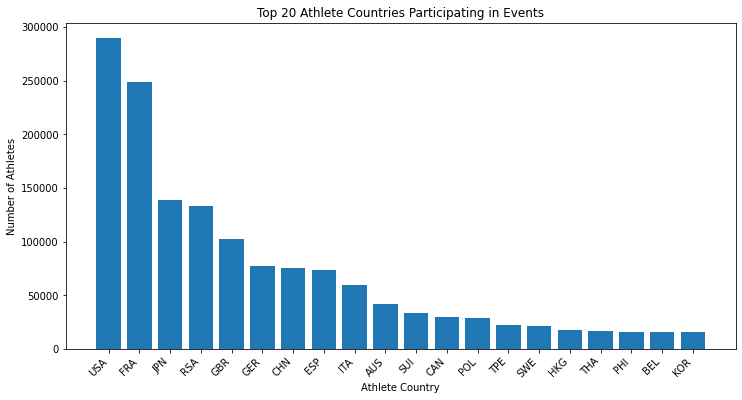

In [0]:
top_countries = running_df.groupBy("athlete_country").agg(countDistinct("athlete_id").alias("num_athletes"))

top_countries = top_countries.orderBy(col("num_athletes").desc())

top20_countries = top_countries.limit(20)
top20_countries_pd = top20_countries.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(top20_countries_pd["athlete_country"], top20_countries_pd["num_athletes"])
plt.title('Top 20 Athlete Countries Participating in Events')
plt.xlabel('Athlete Country')
plt.ylabel('Number of Athletes')
plt.xticks(rotation=45, ha='right') 
plt.show()

In this section, I examine the distribution of gender participation in ultra-marathon races. The code groups the data by athlete gender, calculates the count of participants for each gender, and computes the percentage of men and women in the total dataset. The resulting percentages are then visualized using a bar chart, where red bars represent the percentage of female participants, and blue bars represent the percentage of male participants. 

From the graph we can see that most of the athletes (80%) are men.

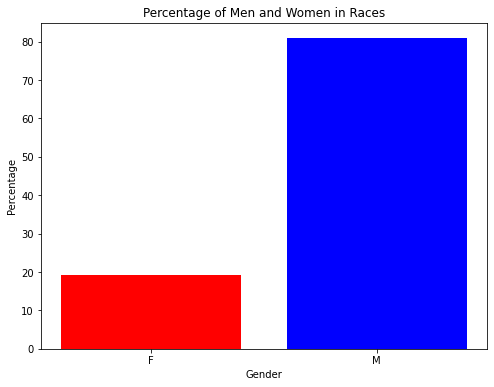

In [0]:
filtered_rows_gender = (
    running_df.groupBy("athlete_gender")
        .agg(count("*").alias("count"))
        .withColumn("percentage", col("count") / lit(total_rows) * 100)
)

gender_counts_pd = filtered_rows_gender.toPandas()
#gender_counts_pd["athlete_gender"] = gender_counts_pd["athlete_gender"].fillna("Unknown")
gender_counts_pd = gender_counts_pd[gender_counts_pd["athlete_gender"].isin(["F", "M"])]

plt.figure(figsize=(8, 6))
plt.bar(gender_counts_pd["athlete_gender"], gender_counts_pd["percentage"], color=["red", 'blue'])
plt.title('Percentage of Men and Women in Races')
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.show()

This section investigates the average running speeds of male and female athletes in races. The code filters the dataset to include only male and female participants from the years 1970 to 2022. It then selects relevant columns, including athlete gender, the year of the event, and the athlete's average speed. The resulting data is organized to calculate the average speed for each gender per year. 

The code creates a line plot, comparing the average speeds of male and female athletes over the specified time frame. The plot is colored, with blue representing male athletes and red representing female athletes, providing a visual comparison of the average speeds between genders.

The graph illustrates that, on average, males tend to have faster running speeds than females. However the difference between male and female speed is narrowing over time and the speed of both sexes is decreasing. This trend could be attributed to factors such as increased participation by diverse individuals with varying running abilities, changing demographics, evolving event types, and shifts in training approaches. The growing popularity of ultra-marathons might attract a more diverse group of participants, including those who prioritize completing the race over achieving faster speeds. The combination of these factors likely contributes to the observed pattern.

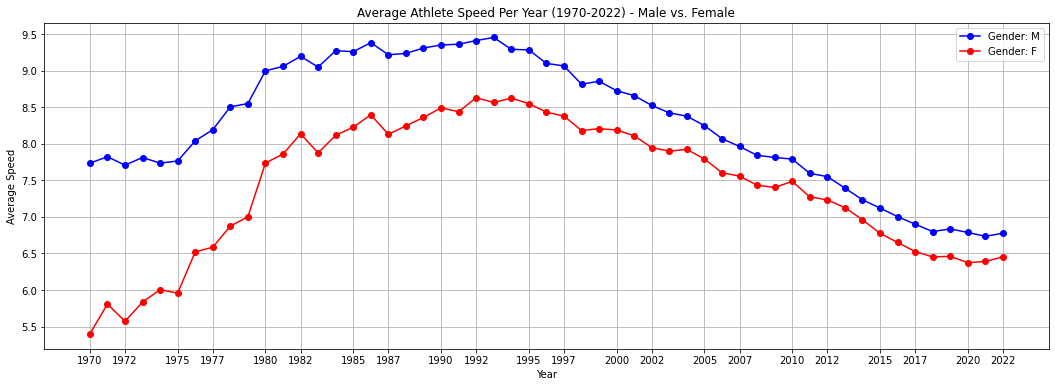

In [0]:
average_speed_gender = running_df.filter((col("athlete_gender").isin(["M", "F"])) &
                                (col("year_of_event") >= 1970) & (col("year_of_event") <= 2022))
average_speed_gender = average_speed_gender.select("athlete_gender", "year_of_event", "athlete_average_speed").orderBy("year_of_event", ascending=True)
average_speed_per_year = average_speed_gender.groupBy("athlete_gender", "year_of_event").agg(avg("athlete_average_speed").alias("avg_speed_per_year"))

pandas_df = average_speed_per_year.toPandas()
plt.figure(figsize=(18, 6))

# for gender in ["M", "F"]:
#    gender_data = pandas_df[pandas_df["athlete_gender"] == gender]
#    plt.plot(gender_data['year_of_event'], gender_data['avg_speed_per_year'], marker='o', linestyle='-', label=f'Gender: {gender}')

# changing colours
for gender, color in zip(["M", "F"], ['blue', 'red']):
    gender_data = pandas_df[pandas_df["athlete_gender"] == gender]
    plt.plot(gender_data['year_of_event'], gender_data['avg_speed_per_year'], marker='o', linestyle='-', color=color, label=f'Gender: {gender}')

plt.title('Average Athlete Speed Per Year (1970-2022) - Male vs. Female')
plt.xlabel('Year')
plt.ylabel('Average Speed')
plt.xticks(pandas_df['year_of_event'][::5])
plt.legend()
plt.grid(True)
plt.show()

This part of the code focuses on the progression of gender representation in ultra-marathon races over the years. The result is creating a table that displays the number of male and female participants for each year. The line plot visualizes this progression, with blue representing male participants and red representing female participants. The chart provides a clear overview of how the participation of both genders has evolved in ultra-marathon races over the specified time period. The visualization highlights the increasing popularity of ultra races in general and emphasizes the trend of growing participation, particularly among male participants. 

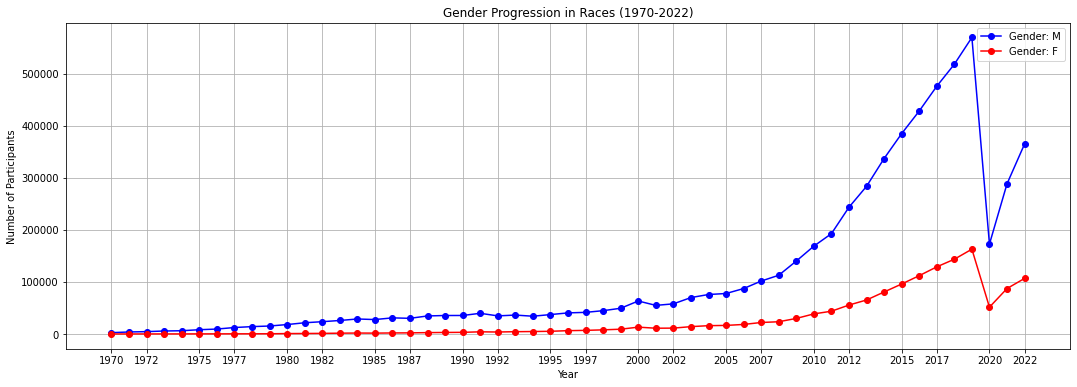

In [0]:
gender_in_years_df = running_df.filter((col("athlete_gender").isin(["M", "F"])) &
                                (col("year_of_event") >= 1970) & (col("year_of_event") <= 2022))
gender_in_years_df = gender_in_years_df.select("athlete_gender", "year_of_event")
gender_progression = gender_in_years_df.groupBy("year_of_event", "athlete_gender").count().orderBy("year_of_event")

pivoted_df = gender_progression.groupBy("year_of_event").pivot("athlete_gender").sum("count").orderBy("year_of_event")
gender_in_years_pandas = pivoted_df.toPandas()

plt.figure(figsize=(18, 6))
#plt.plot(gender_in_years_pandas['year_of_event'], gender_in_years_pandas['F'], marker='o', linestyle='-', label='Women')
#plt.plot(gender_in_years_pandas['year_of_event'], gender_in_years_pandas['M'], marker='o', linestyle='-', label='Men')

# changing colours
for gender, color in zip(["M", "F"], ['blue', 'red']):
    plt.plot(gender_in_years_pandas['year_of_event'], gender_in_years_pandas[gender], marker='o', linestyle='-', color=color, label=f'Gender: {gender}')

plt.title('Gender Progression in Races (1970-2022)')
plt.xlabel('Year')
plt.xticks(pandas_df['year_of_event'][::5])
plt.ylabel('Number of Participants')
plt.legend()
plt.grid(True)
plt.show()

The primary focus of this part of analysis is on the average age of athletes in ultra-marathon races covering the period from 1970 to 2022. The following code filters the dataset to include only relevant columns such as athlete gender, athlete year of birth, and the year of the event. It then calculates the age of each athlete by subtracting their year of birth from the year of the event. After grouping the data by athlete gender and year of the event, the code calculates the average age for each group. The resulting line plot visualizes the average age progression over time, with blue representing male athletes and red representing female athletes. 

The overall trend is an increase in average age for both genders over time. However, the rate of increase is faster for female athletes than for male athletes. This results in a narrowing of the gender gap in average age over time. In 1972, the average age of male athletes was 35 years old, while the average age of female athletes was 38 years old. This means that female athletes were, on average, 3 years older than male athletes in 1972. By 2022, the average age of male athletes had increased to 44 years old, while the average age of female athletes had increased to 43 years old.

There are several possible explanations for the observed trends. One possibility is that ultra-marathons are becoming more popular among older athletes. Another possibility is that older athletes are more likely to participate in ultra-marathons than they were in the past. This could be due to factors such as improved training methods and better access to healthcare.

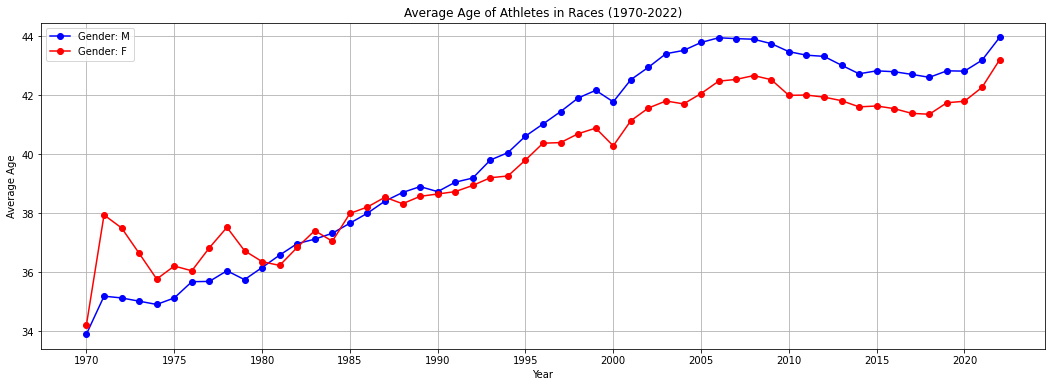

In [0]:
# average age of the athletes (F/M) for races 1970-2022
filtered_df = running_df.filter((year(col("year_of_event")) >= 1970) & (year(col("year_of_event")) <= 2022))
filtered_df = filtered_df.select("athlete_gender", "athlete_year_of_birth", "year_of_event").orderBy("year_of_event", ascending=True)

filtered_df = filtered_df.withColumn("athlete_age", col("year_of_event") - col("athlete_year_of_birth"))

# Group by athlete gender and calculate the average age
average_age_df = filtered_df.groupBy("athlete_gender", "year_of_event").agg(round(avg("athlete_age"), 2).alias("average_age"))

average_age_pd = average_age_df.toPandas().dropna()

plt.figure(figsize=(18, 6))
for gender, color in zip(["M", "F"], ['blue', 'red']):
    gender_data = average_age_pd[average_age_pd["athlete_gender"] == gender]
    plt.plot(gender_data['year_of_event'], gender_data['average_age'], marker='o', linestyle='-', color=color, label=f'Gender: {gender}')

plt.title('Average Age of Athletes in Races (1970-2022)')
plt.xlabel('Year')
plt.ylabel('Average Age')
plt.xticks(gender_data['year_of_event'][::5])
plt.legend()
plt.grid(True)
plt.show()

My next goal is to enrich the understanding of how economic factors, specifically GDP, may correlate or influence the participation and performance of athletes in races. By integrating GDP data with the athlete dataset, the analysis aims to explore potential connections between economic indicators and the trends observed in ultra-marathon participation, providing a broader context for interpreting the findings. 

By reaching this point we are getting to the part that requires the most additional editing and refactoring. For authenticity, I leave the code almost in its original form, where you can see the way of thinking and the chosen style of problem-solving.

This adventure begins by reading GDP data from a CSV file, renaming relevant columns, and attempting manual replacement of missing values. 

In [0]:
gdp_df = spark.read.csv("s3://projectdata//gdp.csv", header=True) 
column_mapping_gdp = {
    "Country Name": "country_name",
    "Country Code": "country_code",
    "Indicator Name": "indicator_name",
    "Indicator Code": "indicator_code"
}

for old_col, new_col in column_mapping_gdp.items():
    gdp_df = gdp_df.withColumnRenamed(old_col, new_col)
    
gdp_df_country = gdp_df.select("country_name", "country_code", "2021")
athletes_gdp = running_df.withColumn(
    "athlete_country",
    when(col("athlete_country") == "GER", "DEU")
    .when(col("athlete_country") == "SUI", "CHE")
    .when(col("athlete_country") == "NED", "NLD")
    .when(col("athlete_country") == "IRE", "IRL")
    .when(col("athlete_country") == "POR", "PRT")
    .when(col("athlete_country") == "DEN", "DNK")
    .otherwise(col("athlete_country"))
)
athletes_gdp = athletes_gdp.join(gdp_df_country, athletes_gdp.athlete_country == gdp_df_country.country_code,  "left")

athletes_gdp = athletes_gdp.withColumn("country_name", when(col("athlete_country") == "TPE", lit("Taiwan")).otherwise(col("country_name")))
athletes_gdp = athletes_gdp.withColumn("2021", when(col("athlete_country") == "TPE", lit(32756.0)).otherwise(col("2021")))
athletes_gdp = athletes_gdp.withColumn("country_code", when(col("athlete_country") == "TPE", lit("TPE")).otherwise(col("country_code")))

In [0]:
# finding out that manual replacement in not right choice
filtered_df_gdp = athletes_gdp.filter(col("country_code").isNull())
filtered_df_gdp = filtered_df_gdp.select("athlete_id", "athlete_country").distinct()
filtered_df_gdp = filtered_df_gdp.groupBy("athlete_country").agg(countDistinct("athlete_id").alias("num_athletes")).orderBy("num_athletes", ascending=False)

filtered_df_gdp.show(filtered_df_gdp.count(), truncate=False)

+---------------+------------+
|athlete_country|num_athletes|
+---------------+------------+
|RSA            |132959      |
|PHI            |16175       |
|MAS            |13895       |
|GRE            |5683        |
|SLO            |3273        |
|BUL            |2998        |
|VIE            |2292        |
|CRO            |2021        |
|INA            |1998        |
|LAT            |1571        |
|GUA            |1232        |
|CRC            |1149        |
|MAD            |1134        |
|ZIM            |1092        |
|URU            |814         |
|BRU            |755         |
|NEP            |585         |
|MGL            |425         |
|MRI            |404         |
|PAR            |364         |
|OMA            |251         |
|LES            |219         |
|IRI            |203         |
|ALG            |200         |
|ESA            |197         |
|BOT            |189         |
|KOS            |151         |
|NCA            |107         |
|PUR            |93          |
|KSA    

After realising that manual replacement is not an optimal choice, I then create a CSV with missing countries (filtered_df_gdp) and adding correct country code using the AI Bard. Afterward, I am joining the missing country information back into the athlete data, handling missing values more systematically. This part concludes by dropping unnecessary columns and displaying the final joined dataset. 

In [0]:
country_codes_df = spark.read.csv("s3://projectdata/country_code.csv", header=True) 
column_mapping_gdp = {
    "Country Code": "country_code_old",
    "Country": "country",
}

for old_col, new_col in column_mapping_gdp.items():
    country_codes_df = country_codes_df.withColumnRenamed(old_col, new_col)

country_codes_df = country_codes_df.join(gdp_df_country, country_codes_df.country == gdp_df_country.country_name, "left")

column_mapping_codes = {
    "2021": "2021_gdp",
    "country_name": "country_name_gdp",
    "country_code": "country_code_gdp"
}

for old_col, new_col in column_mapping_codes.items():
    country_codes_df = country_codes_df.withColumnRenamed(old_col, new_col)

joined_df_athletes_gdp = athletes_gdp.join(country_codes_df, athletes_gdp.athlete_country == country_codes_df.country_code_old, "left")

joined_df_athletes_gdp = joined_df_athletes_gdp.withColumn("2021", coalesce(joined_df_athletes_gdp["2021"], joined_df_athletes_gdp["2021_gdp"]))
joined_df_athletes_gdp = joined_df_athletes_gdp.withColumn("country_name", coalesce(joined_df_athletes_gdp["country_name"], joined_df_athletes_gdp["country"]))
joined_df_athletes_gdp = joined_df_athletes_gdp.withColumn("country_name", coalesce(joined_df_athletes_gdp["country_name"], joined_df_athletes_gdp["country_name_gdp"]))

columns_to_drop = ["2021_gdp", "country_code_old", "country_name_gdp", "country", "country_code_gdp"]
joined_df_athletes_gdp = joined_df_athletes_gdp.drop(*columns_to_drop)
joined_df_athletes_gdp.show()

+-------------+-----------+-------------------+---------------------+-------------------+-------------------+--------------------+---------------+---------------------+--------------+--------------------+---------------------+----------+----------+---------------+------------+----------------+
|year_of_event|event_dates|         event_name|event_distance_length|event_num_finishers|athlete_performance|        athlete_club|athlete_country|athlete_year_of_birth|athlete_gender|athlete_age_category|athlete_average_speed|athlete_id|event_type|   country_name|country_code|            2021|
+-------------+-----------+-------------------+---------------------+-------------------+-------------------+--------------------+---------------+---------------------+--------------+--------------------+---------------------+----------+----------+---------------+------------+----------------+
|         2018| 06.01.2018|Selva Costera (CHI)|                 50km|                 22|          4:51:39 h|      

In this part I verify that everything went correctly and the result shows me the list of the countries, where GDP is missing. The presence of missing GDP data for countries like CHI (Chile), VEN (Venezuela), AND (Andorra), IRI (Iran), IVB (British Virgin Islands), LIE (Liechtenstein), or CUB (Cuba) can be attributed to various factors, including distinctive economic structures, political instability, challenges in data collection, and diplomatic considerations. However, the number of athletes for these countries is low, so this fact is not important for further analysis.

In [0]:
filtered_df_gdp = joined_df_athletes_gdp.filter(col("2021").isNull())
filtered_df_gdp = filtered_df_gdp.select("athlete_id", "athlete_country").distinct()
filtered_df_gdp = filtered_df_gdp.groupBy("athlete_country").agg(countDistinct("athlete_id").alias("num_athletes")).orderBy("num_athletes", ascending=False)

filtered_df_gdp.show(filtered_df_gdp.count(), truncate=False)

+---------------+------------+
|athlete_country|num_athletes|
+---------------+------------+
|CHI            |2406        |
|VEN            |933         |
|AND            |481         |
|IRI            |203         |
|IVB            |70          |
|LIE            |68          |
|MON            |47          |
|CUB            |28          |
|BER            |20          |
|SYR            |15          |
|GRL            |13          |
|FRO            |10          |
|PLE            |8           |
|ERI            |7           |
|GIB            |6           |
|BAH            |5           |
|GUM            |5           |
|PYF            |5           |
|YEM            |4           |
|CGO            |4           |
|YUG            |3           |
|COK            |3           |
|null           |2           |
|Ned            |2           |
|XXX            |2           |
|AHO            |1           |
|ACT            |1           |
|NFI            |1           |
|TKM            |1           |
|swe    

Now I am calculating the correlation between the GDP of countries in 2021 and the number of athletes from each country. For this purpose I'm using the correlation coefficient to quantify the strength of the relationship between these two variables. 

In [0]:
joined_df_athletes_gdp = joined_df_athletes_gdp.filter(col("year_of_event") == 2021)
athlete_count_per_country = joined_df_athletes_gdp.groupBy("athlete_country", round("2021").alias("gdp_2021")).agg(countDistinct("athlete_id").alias("num_athletes"))
correlation_value = athlete_count_per_country.stat.corr("gdp_2021", "num_athletes")
print(f"Correlation between GDP and Number of Athletes: {correlation_value}")

Correlation between GDP and Number of Athletes: 0.2353751658379885


The correlation value of around 0.24 indicates a positive link between a country's GDP in 2021 and the number of athletes from that country. As a country's GDP rises, there's a moderate tendency for more athletes to participate. To illustrate this, I'll use a scatter plot with the number of athletes on the x-axis and GDP on the y-axis for each country in 2021.

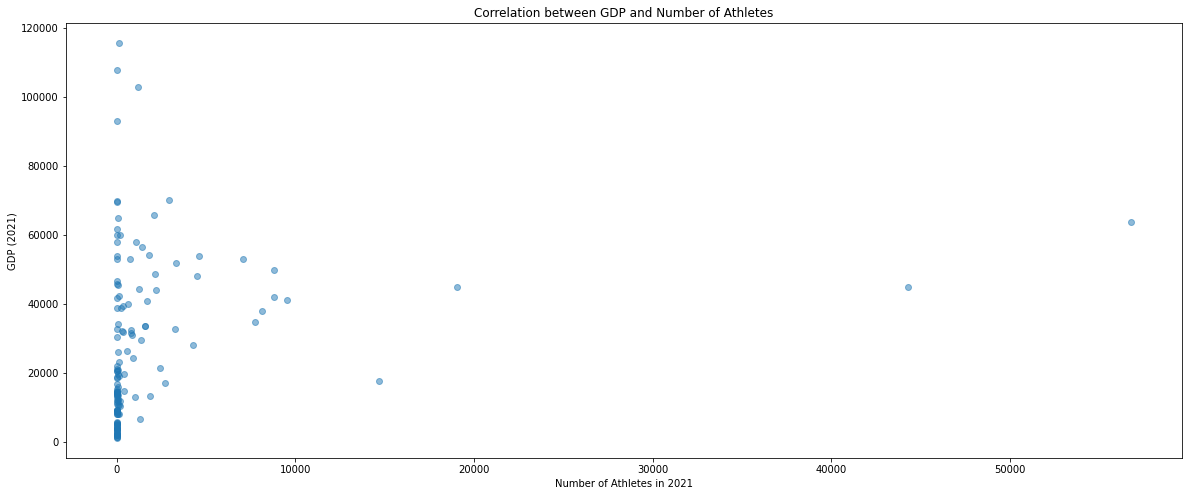

In [0]:
athlete_count_per_country_pd = athlete_count_per_country.select("athlete_country", "gdp_2021", "num_athletes").toPandas()
athlete_count_per_country_pd = athlete_count_per_country_pd.dropna()

# athlete_count_per_country_pd = athlete_count_per_country_pd[(athlete_count_per_country_pd["num_athletes"] <= 50)]

plt.figure(figsize=(20, 8))
plt.scatter(athlete_count_per_country_pd['num_athletes'], athlete_count_per_country_pd['gdp_2021'], alpha=0.5)
plt.title('Correlation between GDP and Number of Athletes')
plt.xlabel('Number of Athletes in 2021')
plt.ylabel('GDP (2021)')
plt.show()

### Czech Ultra Races

Given the global nature of ultra-marathons, this section narrows down the analysis to focus specifically on Czech races and athletes. The Czech Republic hosts an extensive number of ultra-marathon events, totaling 140 races, as evident from the list below.

In [0]:
czech_races = running_df.filter(col("event_name").contains("CZE"))
czech_races_distinct = czech_races.select("event_name").distinct()
czech_races_distinct.show(czech_races_distinct.count(), truncate=False)               

+---------------------------------------------------------+
|event_name                                               |
+---------------------------------------------------------+
|Malohanácká stovka (CZE)                                 |
|Prazska Stovka - Prager Ultratrail 62km (CZE)            |
|Běh na 24 hodin Pilsen - 100km Split (CZE)               |
|Self-Transcendence 12 h race Prag (CZE)                  |
|MiniTMMTR - TransMoravian Masochist Trail Run (CZE)      |
|Brněnský masakr 63 Km (CZE)                              |
|Běh na 24 hodin Pilsen (CZE)                             |
|Strom Ultra Maraton (CZE)                                |
|Libouchecky Ultramaraton 100 Km (CZE)                    |
|Silva Nortica Run 103 km (CZE)                           |
|Ultramaraton Borak (CZE)                                 |
|Krkonosska padesatka 2018 (CZE)                          |
|Mácháč Run Fest 60 Km (CZE)                              |
|Self-Transcendence 6 h race Prag (CZE) 

Now I want to examine the history of 50km and 100km ultra-marathon races in Czech Republic from 1970 to 2022. The following code selects the most popular races, then filters and counts the races for each distance, visualizes the results in two line plots, showcasing the trend of race counts over the years.

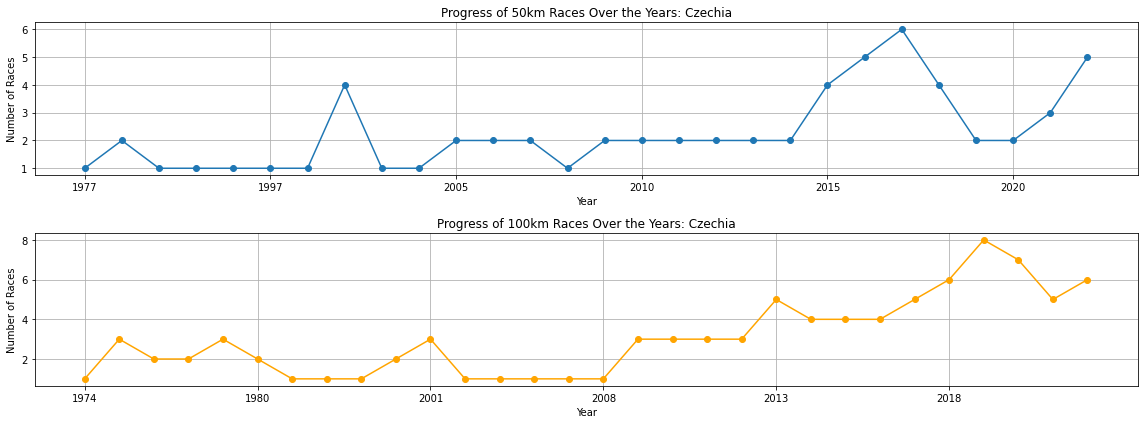

In [0]:
events_count_filtered_cz = czech_races.filter(
    (czech_races["year_of_event"] >= 1970) & 
    (czech_races["year_of_event"] <= 2022) & 
    (czech_races["event_distance_length"] != "None"))
events_count_cz = events_count_filtered_cz.groupBy("year_of_event", "event_distance_length").agg(countDistinct("event_name").alias("event_count")).orderBy("event_distance_length", ascending=False)
events_count_cz = events_count_cz.select("event_distance_length", "event_count", "year_of_event").distinct().orderBy("event_count", ascending=False)
events_50km_cz = events_count_cz.filter(col("event_distance_length") == "50km").orderBy("year_of_event", ascending=True)
events_100km_cz = events_count_cz.filter(col("event_distance_length") == "100km").orderBy("year_of_event", ascending=True)


pandas_df_50km_cz = events_50km_cz.toPandas()
pandas_df_100km_cz = events_100km_cz.toPandas()
fig, axs = plt.subplots(2, 1, figsize=(16, 6))

# 50km races
axs[0].plot(pandas_df_50km_cz['year_of_event'], pandas_df_50km_cz['event_count'], marker='o')
axs[0].set_title('Progress of 50km Races Over the Years: Czechia')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Number of Races')
axs[0].set_xticks(pandas_df_50km_cz['year_of_event'][::5]) 
axs[0].grid(True)

# 100km races
axs[1].plot(pandas_df_100km_cz['year_of_event'], pandas_df_100km_cz['event_count'], marker='o', color='orange')
axs[1].set_title('Progress of 100km Races Over the Years: Czechia')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Number of Races')
axs[1].set_xticks(pandas_df_100km_cz['year_of_event'][::5]) 
axs[1].grid(True)

plt.tight_layout()
plt.show()

In this part of the code, I am identifying the top ultra-marathon event in the Czech Republic based on the maximum number of finishers. After analyzing the history of this particular race (Krakonosova Stovka - 55 km, short route), which is relativly short, I decided not to apply an illustration of the progress of the finalists over the years for the identified event.

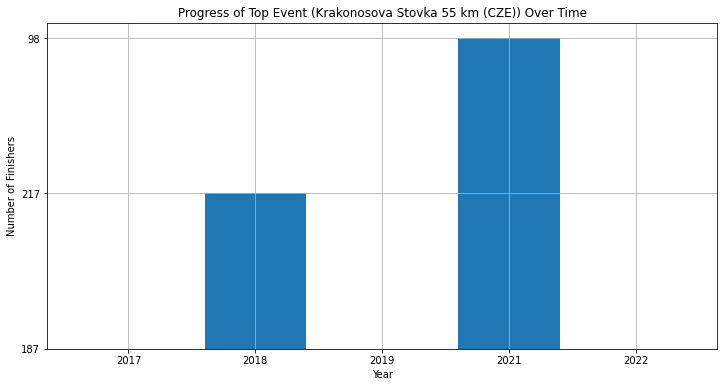

In [0]:
top_cz_event = (czech_races.groupBy("event_name").agg(max("event_num_finishers").alias("max_finishers")).orderBy(desc("max_finishers")).limit(1))
top_cz_event_name = top_cz_event.select("event_name").first()[0]

print(f"Top ultra-marathon event in the Czech Republic based on the maximum number of finisher: {top_cz_event_name}")